<a href="https://colab.research.google.com/github/n2cholas/dsc-workshops/blob/master/Introduction_to_Neural_Networks_with_TensorFlow_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Neural Networks in TensorFlow 2.0
By Nicholas Vadivelu (nicholas.vadivelu@gmail.com)

## Workshop Overview

1.   What is TensorFlow?
2.   Linear Regression 
3.   Gradient Descent
3.   Multivariate Logistic Regression
4.   Neural Networks
5.   Intro to tf.keras

## What is Machine Learning?

*  **Supervised Learning**: given some input $X$ (called features), predict $y$ (called the target)
*  Given data, we train a Machine Learning Model
  *  A simple model:  $y = mx + b$
*  Training involves finding the best $m$ and $b$ for the data
*  Applications include classifying images, generating text, predicting stocks, etc.


# Introduction to TensorFlow

TensorFlow is a open source numerical computation library designed for machine learning. Its key advantages over libraries like numpy and scipy are its support for hardware acceleration (GPUs, TPUs, etc), automatic differentiation, and end-to-end ecosystem for designing and deploying machine learning models.

The recent 2.0 update revamped the library for ease of use, making the API feel similar to numpy and PyTorch (another deep learning library). 

In [2]:
%tensorflow_version 2.x # Enables version 2.0
import tensorflow as tf

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # Enables version 2.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


TensorFlow is a library for manipulation **tensors**, which are essentialy multidimensional arrays.

In [3]:
x = tf.convert_to_tensor([1, 2, 3, 4])
x

<tf.Tensor: id=0, shape=(4,), dtype=int32, numpy=array([1, 2, 3, 4], dtype=int32)>

You can read all about Tensors in the [documentation](https://https://www.tensorflow.org/api_docs/python/tf/Tensor). The key ideas are they have a data type (dtype), a shape, and a numeric value (numpy array).

Unlike Python lists, you can do **vectorized operations**:

In [4]:
2*x + 1

<tf.Tensor: id=4, shape=(4,), dtype=int32, numpy=array([3, 5, 7, 9], dtype=int32)>

Just like numpy, TensorFlow supports **broadcasting**. Here's a brief example. Suppose you want to add a vector to every row of a matrix:

In [0]:
vec = tf.convert_to_tensor([1, 2, 3, 4])
matrix = tf.convert_to_tensor([[1, 1, 1, 1],
                               [4, 4, 4, 4],
                               [5, 5, 5, 5]])

With normal lists, you might be inclined to do something like this:

In [6]:
matrix[1, :] # second row of the matrix

<tf.Tensor: id=10, shape=(4,), dtype=int32, numpy=array([4, 4, 4, 4], dtype=int32)>

In [7]:
for i in range(3):
  matrix[i, :] += vec

TypeError: ignored

Oops, you can't assign values to a Tensor! In general, computations create a new Tensor instead of modifying an existing one. If you need something that is modifable, use a variable. Read more about those [here](https://www.tensorflow.org/api_docs/python/tf/Variable)

In [8]:
matrix = tf.Variable([[1, 1, 1, 1],
                      [4, 4, 4, 4],
                      [5, 5, 5, 5]])
matrix

<tf.Variable 'Variable:0' shape=(3, 4) dtype=int32, numpy=
array([[1, 1, 1, 1],
       [4, 4, 4, 4],
       [5, 5, 5, 5]], dtype=int32)>

Now, back to adding this vector to the matrix. If you add them directly, broadcasting will see that the all the dimensions of `vec` and `matrix` match except for one, so it will duplicate vec along that dimension so the addition works. 

In [9]:
matrix + vec

<tf.Tensor: id=26, shape=(3, 4), dtype=int32, numpy=
array([[2, 3, 4, 5],
       [5, 6, 7, 8],
       [6, 7, 8, 9]], dtype=int32)>

Now we can assign this new value to matrix:

In [10]:
matrix.assign(matrix + vec)

<tf.Variable 'UnreadVariable' shape=(3, 4) dtype=int32, numpy=
array([[2, 3, 4, 5],
       [5, 6, 7, 8],
       [6, 7, 8, 9]], dtype=int32)>

[Here's](https://scipy-lectures.org/intro/numpy/operations.html#broadcasting) a more detailed overview of broadcasting.

We can create scalar tensors and variables:

In [11]:
x = tf.Variable(0)
v = tf.convert_to_tensor(1)

x + v

<tf.Tensor: id=39, shape=(), dtype=int32, numpy=1>


Take a few minutes to explore Tensors and Variables. Create some, play with them, and use the documentation to figure out what they can and can't do!

## Introduction to Linear Regression

We're going to start by fitting a line ($y = mx + b$) to some simulated data in TensorFlow. Suppose have some data:

In [12]:
x = tf.range(1., 5., 0.1) # ensure all the inputs are floats!
x

<tf.Tensor: id=43, shape=(40,), dtype=float32, numpy=
array([1.       , 1.1      , 1.2      , 1.3000001, 1.4000001, 1.5000001,
       1.6000001, 1.7000002, 1.8000002, 1.9000002, 2.0000002, 2.1000001,
       2.2      , 2.3      , 2.3999999, 2.4999998, 2.5999997, 2.6999996,
       2.7999995, 2.8999994, 2.9999993, 3.0999992, 3.199999 , 3.299999 ,
       3.399999 , 3.4999988, 3.5999987, 3.6999986, 3.7999985, 3.8999984,
       3.9999983, 4.0999985, 4.1999984, 4.2999983, 4.399998 , 4.499998 ,
       4.599998 , 4.699998 , 4.799998 , 4.8999977], dtype=float32)>

Above we've created our x values, which is our **explanatory variable**. We will simulate a **response variable** y, which has the relationship $y = 3.5x - 1$, plus some noise.

In [13]:
y = 3.5*x - 1 + tf.random.uniform(shape=(40,), minval=-1, maxval=1, dtype=tf.float32)
y

<tf.Tensor: id=55, shape=(40,), dtype=float32, numpy=
array([ 1.5081716,  3.4402354,  3.565304 ,  2.9521132,  4.642995 ,
        5.1984725,  4.033718 ,  4.244085 ,  5.6146545,  6.6339474,
        6.4838257,  6.9260926,  6.266905 ,  6.4089746,  6.5717545,
        6.8176184,  7.19166  ,  9.247049 ,  7.9582567, 10.14625  ,
        8.848628 , 10.280046 ,  9.729949 , 10.760101 , 11.438638 ,
       11.2754   , 11.156017 , 11.16319  , 12.735874 , 13.418887 ,
       12.87348  , 13.070494 , 13.1910925, 13.565499 , 14.655623 ,
       14.032754 , 15.643642 , 16.414732 , 16.290714 , 16.515282 ],
      dtype=float32)>

Let's see how our data looks:

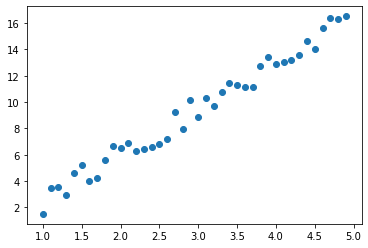

In [14]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.scatter(x, y)

When we fit a linear model to data, we want to find the values of **parameters** $m$ and $b$ to make our line best represent our data. Let's createt these variables first:

In [0]:
m = tf.Variable(1, dtype=tf.float32) # explicitly set the data type, because the initial value is an integer
b = tf.Variable(0, dtype=tf.float32)

Let's see our line looks before fitting it to data:

In [16]:
y_pred = x*m + b # notice y is a vector, we are doing a vectorized operation here on all the entries of x
y_pred

<tf.Tensor: id=97, shape=(40,), dtype=float32, numpy=
array([1.       , 1.1      , 1.2      , 1.3000001, 1.4000001, 1.5000001,
       1.6000001, 1.7000002, 1.8000002, 1.9000002, 2.0000002, 2.1000001,
       2.2      , 2.3      , 2.3999999, 2.4999998, 2.5999997, 2.6999996,
       2.7999995, 2.8999994, 2.9999993, 3.0999992, 3.199999 , 3.299999 ,
       3.399999 , 3.4999988, 3.5999987, 3.6999986, 3.7999985, 3.8999984,
       3.9999983, 4.0999985, 4.1999984, 4.2999983, 4.399998 , 4.499998 ,
       4.599998 , 4.699998 , 4.799998 , 4.8999977], dtype=float32)>

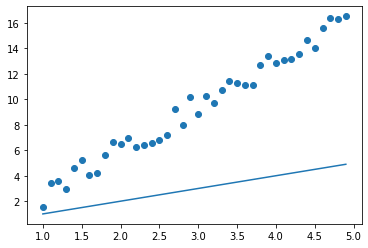

In [17]:
plt.scatter(x, y)
plt.plot(x, y_pred)

Our line doesn't look great. But how do we know when our model is doing well? We will define a numeric measure of how poorly our model is doing. In machine learning, this is called a **loss function**. The larger our loss, the worse our model is. 

For regression, a common loss function is **mean squared error** (MSE):

MSE = $\frac{1}{N}\sum^N_{i=1} (y_{i, true} - y_{i, predicted})^2$

Our goal is to minimize this loss function.

In [0]:
def mse(y_true, y_pred):
  # TensorFlow has this function built in: tf.keras.losses.MSE(y_true, y_pred)
  return tf.reduce_mean((y_true - y_pred)**2)

In [19]:
mse(y, y_pred) # want to minimize this value!

<tf.Tensor: id=182, shape=(), dtype=float32, numpy=49.60046>

For linear regression, we know there's a closed form solution. let's just compute that:

In [20]:
sxx = tf.reduce_mean((x - tf.reduce_mean(x))**2)
sxy = tf.reduce_mean((x - tf.reduce_mean(x))*(y - tf.reduce_mean(y)))

m.assign(sxy/sxx)
b.assign(tf.reduce_mean(y) - m*tf.reduce_mean(x))

y_pred = x*m + b

print(f'Loss: {mse(y, y_pred).numpy()}')

Loss: 0.4125025272369385


Our loss went down (and is minimized, because this is a closed form solution)! Let's check out how this looks graphically:

m: 3.5368335247039795   b: -1.110854148864746


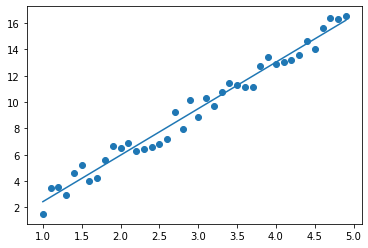

In [21]:
plt.scatter(x, y)
plt.plot(x, y_pred)

print(f'm: {m.numpy()}   b: {b.numpy()}')

Much better! Our parameter values are also very close to the true relationship between $x$ and $y$.

## What if we didn't have a closed form? Gradient Descent!

We have a function $L$ (our loss function, MSE) that we want to minimize by changing our parameters $m$ and $b$. The partial derivative $\frac{\partial L}{\partial m}$ represents the direction of steepest ascent with respect to $m$. If we travel in the direction of the $-\frac{\partial L}{\partial m}$, we are travelling in a direction where our loss function gets smaller. By taking small steps and computing the direction of the derivative at each step, we can slowly make progress towards a local minima. In particular, at every step, here is the update rule:

$m_{k+1} = m_k - \alpha\frac{\partial L}{\partial m}$

$b_{k+1} = b_k - \alpha\frac{\partial L}{\partial b}$

$\alpha$ is our **learning rate**. Typically, this is a value < 1 so we don't take steps that are too large. If our steps are too large, we may never reach the minimum (might jump over the minimum, or diverge altogether). A **gradient** is a vector of partial derivatives of our parameters. Concretely, let $\theta = [m, b]^T$. we can rewrite the above expression concisely as follows.

$\theta_{k+1} = \theta_k - \alpha\nabla_\theta L = \begin{bmatrix} m_k \\ b_k \end{bmatrix} - \alpha \begin{bmatrix} \frac{\partial L}{\partial m} \\ \frac{\partial L}{\partial b} \end{bmatrix}$

Gradient Descent has some drawbacks. It's much slower than a closed form solution. Also, if we have a loss function that isn't **convex**, it could have multiple minima, so our algorithm may converge to a minimum that isn't the global minimum. 

The image below shows the value of an example loss function $J(\theta_0, \theta_1)$ (which could be MSE) plotted against $\theta_0$ and $\theta_1$ (which could be $m$ and $b$).


![alt text](https://hackernoon.com/hn-images/1*f9a162GhpMbiTVTAua_lLQ.png)

For linear regression, we know that the loss function is convex (unlike the picture above), though for machine learning models in general, this is not true.

Let's use gradient descent to fit our linear model.

In [22]:
m = tf.Variable(1, dtype=tf.float32)
b = tf.Variable(0, dtype=tf.float32)
m, b

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>)

We want to iteratively update our parameters in the direction of the negative gradient. TensorFlow supports automatic differentiation, so let's take advantage of that. We use something called a `GradientTape` to track computations in TensorFlow. After tracking them, we are able to differentiate wirth respect to them.

In [23]:
with tf.GradientTape() as tape:
  y_pred = x*m + b
  loss = mse(y_true=y, y_pred=y_pred)

tape.gradient(loss, [m, b])

[<tf.Tensor: id=354, shape=(), dtype=float32, numpy=-44.360188>,
 <tf.Tensor: id=347, shape=(), dtype=float32, numpy=-12.745608>]

The result is the value of the partials with respect to the variables. With GradientTape, computatiosn with Variables are automatically tracked. If you want to differentiate with respect to Tensors, you have to use `tape.watch(tensor)`. We won't cover that in this workshop, but you can check that out [here](https://www.tensorflow.org/tutorials/customization/autodiff).

Now we can write our training loop. We will take 100 steps with a learning rate of 0.05. Here's how that looks:

In [24]:
lr = 0.05 # learning rate

for step in range(100):
  with tf.GradientTape() as tape:
    y_pred = x*m + b
    loss = mse(y_true=y, y_pred=y_pred)

  gradient = tape.gradient(loss, [m, b])
  m.assign_sub(lr*gradient[0])
  b.assign_sub(lr*gradient[1])

  if step % 10 == 0:
    print(f'Loss: {loss.numpy()}')

Loss: 49.600460052490234
Loss: 0.717918336391449
Loss: 0.6513835191726685
Loss: 0.5993430018424988
Loss: 0.558639645576477
Loss: 0.5268036127090454
Loss: 0.5019029378890991
Loss: 0.482427179813385
Loss: 0.46719399094581604
Loss: 0.4552793502807617


Our loss went down, nice! Let's check out the parameter values and the a graph:

m: 3.387526035308838   b: -0.6091350317001343


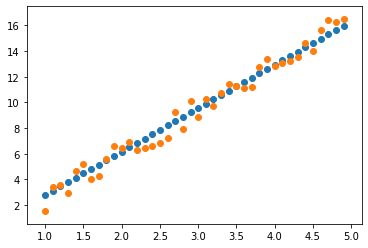

In [25]:
plt.scatter(x, y_pred)
plt.scatter(x, y)

print(f'm: {m.numpy()}   b: {b.numpy()}')

Our code is clean and simple for the simple linear regression case, but it does not scale well. Let's use some classes and objects to clean things up a bit.

In [0]:
class Linear(object):
  def __init__(self):
    self.m = tf.Variable(1, dtype=tf.float32)
    self.b = tf.Variable(0, dtype=tf.float32)
    self.trainable_variables = [self.m, self.b]
  
  def __call__(self, x): # assume x is a row vector
    return self.m * x + self.b

The class above is a callable. When you call it with some input, it'll apply the linear function.

In [27]:
lr = 0.05 # learning rate

linear_model = Linear()

for step in range(100):
  with tf.GradientTape() as tape:
    y_pred = linear_model(x)
    loss = mse(y_true=y, y_pred=y_pred)

  gradient = tape.gradient(loss, linear_model.trainable_variables)
  
  for partial, variable in zip(gradient, linear_model.trainable_variables):
    variable.assign_sub(lr*partial)
  
  if step % 10 == 0:
    print(f'Loss: {loss.numpy()}')

Loss: 49.600460052490234
Loss: 0.717918336391449
Loss: 0.6513835191726685
Loss: 0.5993430018424988
Loss: 0.558639645576477
Loss: 0.5268036127090454
Loss: 0.5019029378890991
Loss: 0.482427179813385
Loss: 0.46719399094581604
Loss: 0.4552793502807617


Let's also encapsulate our gradient update into an object too, to make things even cleaner:

In [0]:
class GradientDescentOptimizer(object):
  def __init__(self, lr=0.05):
    self.lr = 0.05
  
  def apply_gradients(self, grads_and_vars):
    for grad, var in zip(gradient, linear_model.trainable_variables):
      var.assign_sub(self.lr*grad)

In [29]:
linear_model = Linear()
optimizer = GradientDescentOptimizer(lr=0.05)

for step in range(100):
  with tf.GradientTape() as tape:
    y_pred = linear_model(x)
    loss = mse(y_true=y, y_pred=y_pred)

  gradient = tape.gradient(loss, linear_model.trainable_variables)
  optimizer.apply_gradients(zip(gradient, linear_model.trainable_variables))
  
  if step % 10 == 0:
    print(f'Loss: {loss.numpy()}')

Loss: 49.600460052490234
Loss: 0.717918336391449
Loss: 0.6513835191726685
Loss: 0.5993430018424988
Loss: 0.558639645576477
Loss: 0.5268036127090454
Loss: 0.5019029378890991
Loss: 0.482427179813385
Loss: 0.46719399094581604
Loss: 0.4552793502807617


TensorFlow actually gives us exactly this optimizer (with some more bells and whistles, of course): 

In [0]:
from tensorflow.keras.optimizers import SGD

In [31]:
linear_model = Linear()
optimizer = SGD(lr=0.05)

for step in range(100):
  with tf.GradientTape() as tape:
    y_pred = linear_model(x)
    loss = mse(y_true=y, y_pred=y_pred)

  gradient = tape.gradient(loss, linear_model.trainable_variables)
  optimizer.apply_gradients(zip(gradient, linear_model.trainable_variables))
  
  if step % 10 == 0:
    print(f'Loss: {loss.numpy()}')

Loss: 49.600460052490234
Loss: 0.717918336391449
Loss: 0.6513835191726685
Loss: 0.5993430018424988
Loss: 0.558639645576477
Loss: 0.5268036127090454
Loss: 0.5019029378890991
Loss: 0.482427179813385
Loss: 0.46719399094581604
Loss: 0.4552793502807617


SGD stands for Stochastic Gradient Descent. It essentially exactly the same thing as our optimizer. We'll talk about it in more detail later.

## What if we have multiple inputs?

$y = \vec x^T \vec w + b $

Expanded:

$y =  x_1w_1 + x_2w_2 + .... + x_mw_m + b$

<br>

## What if we have multiple outputs as well?

$\vec y = x^T \vec W + \vec b$

Expanded:

$y_1 =  x_1W_{1,1} + x_2W_{2,1} + ... + x_kW_{1,m} + b_1$

$\dots$

$y_n =  x_1W_{k,1} + x_2W_{k,2} + ... + x_kW_{k,m} + b_k$

<br>

Let's update our linear class to support multiple inputs and ouputs.


In [0]:
class Linear(object):
  def __init__(self, input_length, output_length):
    self.W = tf.Variable(tf.ones([input_length, output_length]))
    self.b = tf.Variable(tf.zeros(output_length))
    self.trainable_variables = [self.W, self.b]
  
  def __call__(self, x): # assume x is a row vector
    return x @ self.W + self.b # @ is the matrix multiplication operator

TensorFlow gives us almost exactly this in `tf.keras.layers.Dense`. For now, we will use our class for more transparency.

## MNIST

MNIST is a dataset of handwritten digits from 1 to 9, originally published by Yann Lecun, Corinna Cortes, Christopher J.C. Burges. Let's check it out:

In [0]:
(x, y), _ = tf.keras.datasets.mnist.load_data()

In [0]:
x, y = tf.convert_to_tensor(x), tf.convert_to_tensor(y)

<tf.Tensor: id=16386, shape=(), dtype=uint8, numpy=1>

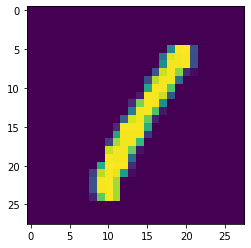

In [35]:
plt.imshow(x[3])
y[3]

#### Exercise:

1.   What's the shape of each image?
2.   How many images do we have in this dataset?
3.   How many of each class do we have?
4.   What's are the datatypes?



In [36]:
x.shape, y.shape # 28*28 images, 60 000 images

(TensorShape([60000, 28, 28]), TensorShape([60000]))

In [37]:
for i in range(10):
  print(f'Number of {i}: {tf.reduce_sum(tf.cast(y == i, tf.int32)).numpy()}')

Number of 0: 5923
Number of 1: 6742
Number of 2: 5958
Number of 3: 6131
Number of 4: 5842
Number of 5: 5421
Number of 6: 5918
Number of 7: 6265
Number of 8: 5851
Number of 9: 5949


In [38]:
x.dtype, y.dtype

(tf.uint8, tf.uint8)

#### Preprocessing

We'll work with just 500 examples, so our code runs faster. We also want to normalize our image values so they're between 0 and 1. This makes makes training our models easier, since the scale of our gradients and parameters are more predictable.

In [0]:
x, y = x[:500], y[:500]
x = tf.cast(x, tf.float32) / 255.0

When we did regression, we assumed our response was a continuous variable. Now, our response is one of 9 categories. It doesn't make sense to fit a line to discrete values from 1 to 9, so we will do something called **one hot encoding**.

Essentially, instead of 1 number representing the category, we have a vector of size 10. This vector has 0s everywhere, except a 1 indicating which category the example corresponds to. [Here](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)'s a great article about why we one hot encode.

Intuitively, this vector represents a probability distribution. In our training data, if our example is a 1, there is a 100% chance it is a 1. So, vec[1] = 100%, while the rest = 0. We will create a model that will predict probabilities for each digit. Our model's prediction is whichever digit it assigned the highest probability.

In [40]:
y = tf.one_hot(y, depth=10)
y

<tf.Tensor: id=16451, shape=(500, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

We will also reshape our explanatory variable from a 28x28 image to a 28*28 long vector, so we can continue to use the techniques we have developed.

In [41]:
x = tf.reshape(x, (-1, 28*28))
x

<tf.Tensor: id=16453, shape=(500, 784), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

Now our dataset contains 60,000 vectors of length 784.

For easy reuse, we'll define a function that does all this for us, in case we need it again:

In [0]:
def preprocess(x, y):
  # Converts numpy arrays to preprocessing tensors
  x, y = tf.convert_to_tensor(x), tf.convert_to_tensor(y)
  x = tf.reshape(x, (-1, 28*28))
  x = tf.cast(x, tf.float32) / 255.0
  y = tf.one_hot(y, depth=10)
  return x, y

Let's jump right into it with our linear model!

In [43]:
x

<tf.Tensor: id=16453, shape=(500, 784), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [0]:
linear_model = Linear(input_length=784, output_length=10)

Broadcasting is what keeps our code so concise. Even though there are 500 training examples, broadcasting will do the matrix multplication on each row of the input matrix (i.e. each example). The output has one output vector per row:

In [45]:
linear_model(x)

<tf.Tensor: id=16475, shape=(500, 10), dtype=float32, numpy=
array([[107.94119 , 107.94119 , 107.94119 , ..., 107.94119 , 107.94119 ,
        107.94119 ],
       [121.94121 , 121.94121 , 121.94121 , ..., 121.94121 , 121.94121 ,
        121.94121 ],
       [ 76.247055,  76.247055,  76.247055, ...,  76.247055,  76.247055,
         76.247055],
       ...,
       [ 81.074524,  81.074524,  81.074524, ...,  81.074524,  81.074524,
         81.074524],
       [ 71.69804 ,  71.69804 ,  71.69804 , ...,  71.69804 ,  71.69804 ,
         71.69804 ],
       [108.50588 , 108.50588 , 108.50588 , ..., 108.50588 , 108.50588 ,
        108.50588 ]], dtype=float32)>

Great...but we wanted our outputs to represent a probability distribution. We need to normalize the output of model so the vector represents a probability distribution.

We are doing what's called **multiclass logistic regression**. The current outputs of our linear model are called **logits**. To get the probabilities, we normalize our output using a function called a **softmax**. Let $\vec y = [y_1, y_2, .... y_k]$ be our output vector:

$softmax(\vec y) = \left\{\frac{\exp(y_i)}{\sum_{j=1}^k \exp(y_j)}\right\}_{i=1...k}$

This forces the sum of the elements to equal 1 (like a probability). You'll notice we don't just normalize--we exponentiate then normalize. Intuitively, the exponent makes large grow faster than small ones. If the model outputs small differences between the classes, this function will make one entry in the vector large and close to one, and the rest close to 0. This will make it easier for our model's output to match the one_hot encoded ground truth.

In [0]:
def softmax(x):
  return tf.math.exp(x) / tf.reduce_sum(tf.math.exp(x))

In [47]:
softmax(linear_model(x))

<tf.Tensor: id=16484, shape=(500, 10), dtype=float32, numpy=
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)>

Yikes, looks like there's some numerical overflow in our softmax. We'll use the built in one to avoid this (there are some tricks to make it stable):

In [48]:
y_pred = tf.nn.softmax(linear_model(x))
y_pred

<tf.Tensor: id=16489, shape=(500, 10), dtype=float32, numpy=
array([[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]], dtype=float32)>

Great, let's check that our probability vectors add up to 1, just like we want.

In [49]:
tf.reduce_sum(y_pred, axis=1)

<tf.Tensor: id=16491, shape=(500,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.,

Since we are doing classification, we can compute accuracy! Let's do that:

In [0]:
def accuracy(y_true, y_pred):
  equal_preds = tf.math.argmax(y_pred, axis=1) == tf.math.argmax(y_true, axis=1)
  return tf.reduce_mean(tf.cast(equal_preds, tf.float32))

In [51]:
accuracy(y, y_pred)

<tf.Tensor: id=16499, shape=(), dtype=float32, numpy=0.1>

As we'd expect, our untrained model has a 10% accuracy, which is as accurate as one would be when randomly guessing.

At this point, you might think we're going to maximize accuracy via gradient descent. Unfortunately, accuracy is not a great measure to do this with. It simple doesn't have enough fine grain information about the discrepancy between our model's predictions and the true y values. Instead, we are going to go back to thinking about our outputs as a probability distribution. We use a loss called **categorical crossentropy**. This essentially measures how far our output vector is from the target vector (our one hot encoded labels). Suppose our prediction/true values are of the form $\vec y = [y_1, y_2, ..., y_k]$ (i.e. we have k classes).

$L(\vec y_{true}, \vec y_{pred}) = - \sum^k_{i=1} y_{i, true}\log(y_{i, prediction})$

Notice that $y_{i, true} = 0$ for all values except for $i = $true class. Also, $\log(y_{i, prediction}) = 0$ when $y_{i, prediction} = 1$. When it's smaller, the value is negative, so our loss is positive. Essentially, this loss 0 when our model output exactly matches the training data, which is what we want.

In [0]:
def categorical_crossentropy(y_true, y_pred):
  return -tf.reduce_sum(y_true*tf.math.log(y_pred), axis=1)

TensorFlow gives us this function too: `tf.keras.losses.categorical_crossentropy`. We can use ours and tensorflow's interchangeably.

In [53]:
categorical_crossentropy(y, y_pred) # this outputs the cross entropy per example

<tf.Tensor: id=16504, shape=(500,), dtype=float32, numpy=
array([2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851,
       2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851,
       2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851,
       2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851,
       2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851,
       2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851,
       2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851,
       2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851,
       2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851,
       2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851,
       2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851,
       2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851,
       2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.3025851, 2.30

Now you have all the tools to write the training loop for logistic regression. Try it before look at the solution below!

In [54]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

linear_model = Linear(28*28, 10)

for i in range(1000):
  with tf.GradientTape() as tape:
    y_pred = tf.nn.softmax(linear_model(x))
    loss_per_example = categorical_crossentropy(y_true=y, y_pred=y_pred)
    loss = tf.reduce_mean(loss_per_example)

  gradient = tape.gradient(loss, linear_model.trainable_variables)
  optimizer.apply_gradients(zip(gradient, linear_model.trainable_variables))
  if i % 100 == 0:
    print(f'Loss: {loss.numpy()}  Accuracy: {accuracy(y_pred, y)}')

Loss: 2.3025851249694824  Accuracy: 0.10000000149011612
Loss: 0.4364985227584839  Accuracy: 0.9039999842643738
Loss: 0.29362964630126953  Accuracy: 0.9440000057220459
Loss: 0.22477126121520996  Accuracy: 0.9660000205039978
Loss: 0.18162311613559723  Accuracy: 0.9819999933242798
Loss: 0.1515568494796753  Accuracy: 0.9860000014305115
Loss: 0.12939059734344482  Accuracy: 0.9919999837875366
Loss: 0.11246717721223831  Accuracy: 0.9980000257492065
Loss: 0.099213607609272  Accuracy: 1.0
Loss: 0.08861198276281357  Accuracy: 1.0


Wow, our model's doing really well! Let's take a look at a prediction:

In [55]:
y_pred[0].numpy()

array([7.2486359e-03, 8.7252660e-03, 1.6632091e-02, 6.6710129e-02,
       2.4541716e-05, 8.8565266e-01, 1.4892247e-03, 4.6367473e-03,
       7.0132478e-03, 1.8675643e-03], dtype=float32)

In [56]:
y[0].numpy()

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

Nice, for this example, our model's outputting a probability of 75% for the most likely class, which is correct. 

But our results are misleading. We are evaluating our model on the same data we trained it on. This is the equivalent of teaching a student some concepts, then testing them on it, BUT giving them the test as prep material. We want to evaluate our model on new examples.

In machine learning, we call this a **test set**. We do not train our model on this data, we only evaluate our model. Typically, we do a random split of our dataset to get a train/test split. MNIST already has this:

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
x_test, y_test = preprocess(x_test, y_test)

In [59]:
y_pred = tf.nn.softmax(linear_model(x_test))
loss = tf.reduce_mean(categorical_crossentropy(y_true=y_test, y_pred=y_pred))
print(f'Loss: {loss.numpy()}  Accuracy: {accuracy(y_pred, y_test)}')

Loss: 0.5398113131523132  Accuracy: 0.8337000012397766


Not great. Our model has **overfit** to our training set, i.e., it has memorized the input data. So, it doesn't generalize well to data it has not seen before. There are many ways to combat this (which are out of the scope of this workshop), but one way is to just give our model more training data. Now, we'll train with the entire train set instead of just 500 examples:

In [0]:
x_train, y_train = preprocess(x_train, y_train)

In [61]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
linear_model = Linear(28*28, 10)

for i in range(1000):
  with tf.GradientTape() as tape:
    y_pred = tf.nn.softmax(linear_model(x_train))
    loss_per_example = categorical_crossentropy(y_true=y_train, y_pred=y_pred)
    loss = tf.reduce_mean(loss_per_example)

  gradient = tape.gradient(loss, linear_model.trainable_variables)
  optimizer.apply_gradients(zip(gradient, linear_model.trainable_variables))
  if i%100 == 0:
    print(f'Loss: {loss.numpy()}  Accuracy: {accuracy(y_pred, y_train)}')

Loss: 2.3025853633880615  Accuracy: 0.09871666878461838
Loss: 0.6087093949317932  Accuracy: 0.8613333106040955
Loss: 0.48937270045280457  Accuracy: 0.877216637134552
Loss: 0.44037213921546936  Accuracy: 0.885450005531311
Loss: 0.41215795278549194  Accuracy: 0.8906000256538391
Loss: 0.39325031638145447  Accuracy: 0.8945833444595337
Loss: 0.37943124771118164  Accuracy: 0.8974999785423279
Loss: 0.3687483072280884  Accuracy: 0.8997833132743835
Loss: 0.3601595163345337  Accuracy: 0.9016333222389221
Loss: 0.3530517518520355  Accuracy: 0.9029833078384399


In [62]:
y_pred = tf.nn.softmax(linear_model(x_test))
loss_per_example = categorical_crossentropy(y_true=y_test, y_pred=y_pred)
loss = tf.reduce_mean(loss_per_example)
print(f'Loss: {loss.numpy()}  Accuracy: {accuracy(y_pred, y_test)}')

Loss: 0.33095377683639526  Accuracy: 0.909600019454956


Now our model doesn't overfit as much, but we can definitely do better. Our logistic regression model has some drawbacks:

1.   It still only models linear relationships between the explanatory and response variables. In particular, the **decision boundary** it models is a plane. This boundary is what determines if the model chooses one class over another.
2.   It assumes the x variables are all independent, i.e., it doesn't model any iteractions between the explanatory variables. Especially in an image like this, it's clear there are are relationships between the variables.




## Introduction to Artificial Neural Networks

From Wikipedia: 

"Artificial neural networks (ANN) or connectionist systems are computing systems that are inspired by, but not identical to, biological neural networks that constitute animal brains. Such systems "learn" to perform tasks by considering examples, generally without being programmed with task-specific rules. "

How can we make our linear or logistic regression more expressive? What if we added more weight matrices?

$\vec y = ((\vec xW_1 + b_1)W_2 + b_2)....W_l + \vec b_l$.

Well this doesn't help, since we can define $W = W_1W_2....W_l$ (and similarly collapse $\vec b$. and it'll just be another linear model. What if we add some nonlinear function $a$ between each linear function?

$\vec y = (a(a(\vec xW_1 + b_1)W_2 + b_2)....)W_l + \vec b_l$

This is called a **fully connected neural network**! $a$ is called the **activation function**. There are many other types of neural networks, such as Convolutional Neural Networks (which work well for images) and Recurrent Neural Networks (which work well for sequences), but they all boil down to this fundamental structure.

Common activation functions include the sigmoid function, tanh, and relu (rectified linear). This one is a common choice, so we will stick to it.

In [0]:
def relu(x):
  return tf.maximum(x, 0)

![alt text](https://miro.medium.com/max/1283/1*DfMRHwxY1gyyDmrIAd-gjQ.png)

Though this function is technically non-linear, even though it doesn't look like it. It's only linear when x > 0. We will not talk about this too much, and just use it.

We need to make a slight modification to our Linear class, then we'll make our neural network class:

In [0]:
class Linear(object):
  def __init__(self, input_length, output_length):
    self.W = tf.Variable(tf.random.normal([input_length, output_length]))
    self.b = tf.Variable(tf.zeros(output_length))
    self.trainable_variables = [self.W, self.b]
  
  def __call__(self, x): # assume x is a row vector
    return x @ self.W + self.b # @ is the matrix multiplication operator

We made our initializer random. Unlike linear/logistic regression, the loss is not convex, i.e. there are multiple local minima. We initialize randomly, so we don't bias towards any particular minimum.

In [0]:
class FullyConnectedNetwork(object):
  def __init__(self, input_length, output_length):
    self.l1 = Linear(input_length, 50)
    self.l2 = Linear(50, output_length)

    self.trainable_variables = self.l1.trainable_variables + self.l2.trainable_variables
  
  def __call__(self, x):
    return tf.nn.softmax(self.l2(tf.nn.relu(self.l1(x))))

This model has 1 **hidden layer** of size 50. Machine learning with neural networks is called **deep learning**, which comes from the fact that a neural network typically has several hidden layers.

Now, write the training loop for our neural network.

In [69]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
neural_network = FullyConnectedNetwork(28*28, 10)

for i in range(1000):
  with tf.GradientTape() as tape:
    y_pred = neural_network(x_train)
    loss_per_example = tf.keras.losses.categorical_crossentropy(y_true=y_train, y_pred=y_pred)
    loss = tf.reduce_mean(loss_per_example)

  gradient = tape.gradient(loss, neural_network.trainable_variables)
  optimizer.apply_gradients(zip(gradient, neural_network.trainable_variables))
  if i % 100 == 0:
    print(f'Loss: {loss.numpy()}  Accuracy: {accuracy(y_pred, y_train)}')

Loss: 13.893878936767578  Accuracy: 0.10978333652019501
Loss: 7.0014495849609375  Accuracy: 0.5102999806404114
Loss: 5.423182964324951  Accuracy: 0.6128833293914795
Loss: 4.862724781036377  Accuracy: 0.6526166796684265
Loss: 4.611066818237305  Accuracy: 0.6717333197593689
Loss: 4.456557273864746  Accuracy: 0.683650016784668
Loss: 4.345137596130371  Accuracy: 0.6911166906356812
Loss: 4.257636547088623  Accuracy: 0.6973999738693237
Loss: 4.185241222381592  Accuracy: 0.701533317565918
Loss: 4.123439788818359  Accuracy: 0.7055833339691162


We wrote our neural network from scratch, but of course TensorFlow has APIs to make this much easier for you.

In [0]:
from tensorflow.keras.layers import Dense

TensorFlow layers function similarly to the ones we created: they have `trainable_variables` you can access, and do computation through a `call` method. They have some other nice properties as well, for example, you don't need to specify an input shape -- this will be computer upon your first use of the model.

You can build a model almost exactly like we did by subclassing tf.keras.Model:

In [0]:
class Model(tf.keras.Model):
  def __init__(self, input_length, output_length):
    super(Model, self).__init__()
    self.layer1 = Dense(50, input_shape=(input_length,), activation='relu')
    self.layer2 = Dense(output_length, input_shape=(output_length,))
  
  def call(self, x):
    output1 = self.layer1(x)
    output2 = self.layer2(output1)
    return tf.nn.softmax(output2)

If you're building a simple model like ours that just stacks computation, you can use the sequential API (notice we don't specify an input shape):

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(50),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [74]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

for i in range(1000):
  with tf.GradientTape() as tape:
    y_pred = model(x_train)
    loss_per_example = tf.keras.losses.categorical_crossentropy(y_true=y_train, y_pred=y_pred)
    loss = tf.reduce_mean(loss_per_example)

  gradient = tape.gradient(loss, model.trainable_variables)
  if i % 100 == 0:
    print(f'Loss: {loss.numpy()}  Accuracy: {accuracy(y_pred, y_train)}')
  optimizer.apply_gradients(zip(gradient, model.trainable_variables))

Loss: 0.2992660701274872  Accuracy: 0.9152833223342896
Loss: 0.2906898856163025  Accuracy: 0.9175333380699158
Loss: 0.2830638587474823  Accuracy: 0.919866681098938
Loss: 0.27615323662757874  Accuracy: 0.9215666651725769
Loss: 0.26982128620147705  Accuracy: 0.9236000180244446
Loss: 0.2639724612236023  Accuracy: 0.9250166416168213
Loss: 0.2585376501083374  Accuracy: 0.926716685295105
Loss: 0.25347232818603516  Accuracy: 0.9281833171844482
Loss: 0.24871543049812317  Accuracy: 0.9294000267982483
Loss: 0.24421274662017822  Accuracy: 0.9306333065032959


I encourage you to read the documentation to learn more about the layers, as there are some tricks that will make these perform slightly better than ours (e.g. initialization).

### Using tf.data

Our model's training well now, but each step is pretty slow. Our update step takes time proportional to the size of our dataset, since our loss/gradients are calculated with respect to the entire training set. Also, when working with larger datasets, this may not even be possible.

Instead, we can compute our loss and gradients with respect to a subset of our data called a **minibatch**. This is great, since our update no longer takes time proportional to our dataset size. The drawback is our update is now **stochastic**, since we are updating our parameters on a random subset of our data. Typically, we split our dataset into minibatches of size 32 - 256.

Let's do this with TensorFlow dataset API, tf.data. It will be much more performant than raw tensors for minibatch gradient descent.

In [0]:
train, test = tf.keras.datasets.mnist.load_data()

Given numpy arrays as input, we can simply turn them into datasets with `from_tensor_slices`. There's the `tensorflow_datasets` library that has many datasets built in

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train)
test_dataset = tf.data.Dataset.from_tensor_slices(test)

We need to do some similar preprocessing of the data. Notice we aren't one_hot encoding y. TensorFlow has a loss function called `sparse_categorical_crossentropy`, which is the same as `categorical_crossentropy` except it allows the `y_true` to be an index instead of a one hot tensor (which is faster and more memory efficient). We need to change our accuracy function to reflect that.

In [0]:
def preprocess_tfdata(x, y):
  x = tf.reshape(x, (1, 28*28))
  x = tf.cast(tf.squeeze(x), tf.float32) / 255.0
  return x, y

def sparse_accuracy(y_true, y_pred):
  equal_preds = tf.math.argmax(y_pred, axis=1) == tf.cast(y_true, tf.int64)
  return tf.reduce_mean(tf.cast(equal_preds, tf.float32))

We apply this preprocessing to our dataset using `map`. Then, we shuffle our data. Since we are batching our data, we don't want to use the same minibatches for every pass of the dataset, because that would introduce bias. Then, we batch our data into batches of size 256. Finally, we prefetch, which means the next batch will be loaded and ready to go before the previous one finishes. There are tons of optimizations you can do to get more performance, which you can read about [here](https://www.tensorflow.org/guide/data_performance).

In [0]:
train_dataset = train_dataset.map(preprocess_tfdata).shuffle(buffer_size=5000)
train_dataset = train_dataset.batch(256).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.map(preprocess_tfdata).batch(256)

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(50),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(10, activation='softmax')
])

Now we can train. This time, our loop looks a bit different. We call every pass of our dataset an **epoch**. Then, each minibatch process is called a **training step**.

In [80]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

for epoch in range(2):
  for step, (x, y) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      y_pred = model(x)
      loss_per_example = loss_fn(y_true=y, y_pred=y_pred)
      loss = tf.reduce_mean(loss_per_example)

    gradient = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    if step % 100 == 0:
      print(f'Epoch {epoch} Step {step} Loss: {loss.numpy()} Accuracy: {sparse_accuracy(y, y_pred)}')

Epoch 0 Step 0 Loss: 2.420623302459717 Accuracy: 0.0703125
Epoch 0 Step 100 Loss: 0.6510080099105835 Accuracy: 0.8515625
Epoch 0 Step 200 Loss: 0.5177682638168335 Accuracy: 0.86328125
Epoch 1 Step 0 Loss: 0.415408730506897 Accuracy: 0.87890625
Epoch 1 Step 100 Loss: 0.4126032888889313 Accuracy: 0.8984375
Epoch 1 Step 200 Loss: 0.365292489528656 Accuracy: 0.89453125


### Metrics

Now our model's training really quickly. But, we're reporting statistics on individual minibatches. Ideally, we can report statistics on the entire training set at the end of each epoch. Or, report statistics on the data we've seen since the previous report. Let's implement this.

In [0]:
class Mean(object):
  def __init__(self):
    self.vals = []

  def add_value(self, x):
    self.vals.append(x)
  
  def result(self):
    return sum(self.vals)/len(self.vals)
  
  def reset_states(self):
    self.vals = []

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(50),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [85]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
loss_mean = Mean()
accuracy_mean = Mean()

for epoch in range(2):
  for step, (x, y) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      y_pred = model(x)
      loss_per_example = loss_fn(y_true=y, y_pred=y_pred)
      loss = tf.reduce_mean(loss_per_example)

    gradient = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    loss_mean.add_value(loss.numpy())
    accuracy_mean.add_value(sparse_accuracy(y, y_pred))
  
    if step % 100 == 0:
      print(f'Epoch {epoch} Step {step} Loss: {loss_mean.result()} Accuracy: {accuracy_mean.result()}')
      loss_mean.reset_states()
      accuracy_mean.reset_states()

Epoch 0 Step 0 Loss: 2.346635580062866 Accuracy: 0.15234375
Epoch 0 Step 100 Loss: 1.2027271282672882 Accuracy: 0.6998828053474426
Epoch 0 Step 200 Loss: 0.5806717258691788 Accuracy: 0.8575390577316284
Epoch 1 Step 0 Loss: 0.43301645602498734 Accuracy: 0.8878348469734192
Epoch 1 Step 100 Loss: 0.42787124931812287 Accuracy: 0.8848046660423279
Epoch 1 Step 200 Loss: 0.4001629453897476 Accuracy: 0.8896093964576721


Of course, TensorFlow already has a way to do this:

In [86]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
loss_metric = tf.keras.metrics.Mean()
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()


for epoch in range(2):
  for step, (x, y) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      y_pred = model(x)
      loss_per_example = loss_fn(y_true=y, y_pred=y_pred)
      loss = tf.reduce_mean(loss_per_example)

    gradient = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    loss_metric(loss)
    accuracy_metric(y_true=y, y_pred=y_pred)
  
    if step % 100 == 0:
      print(f'Epoch {epoch} Step {step} Loss: {loss_metric.result()} Accuracy: {accuracy_metric.result()}')
      loss_metric.reset_states()
      accuracy_metric.reset_states()

Epoch 0 Step 0 Loss: 0.30616647005081177 Accuracy: 0.9140625
Epoch 0 Step 100 Loss: 0.3538685739040375 Accuracy: 0.9021875262260437
Epoch 0 Step 200 Loss: 0.34719112515449524 Accuracy: 0.9018359184265137
Epoch 1 Step 0 Loss: 0.28928661346435547 Accuracy: 0.9163636565208435
Epoch 1 Step 100 Loss: 0.3155575692653656 Accuracy: 0.9126172065734863
Epoch 1 Step 200 Loss: 0.32115286588668823 Accuracy: 0.908007800579071


## We did a bunch of heavy lifting. We don't have to.

Keras has really high level APIs that take care of all the work we did for us.

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(50),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [89]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=256, epochs=10, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 28us/sample - loss: 1.6077 - accuracy: 0.5817 - val_loss: 1.0738 - val_accuracy: 0.7891
Epoch 2/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.8704 - accuracy: 0.8139 - val_loss: 0.6882 - val_accuracy: 0.8476
Epoch 3/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.6321 - accuracy: 0.8508 - val_loss: 0.5457 - val_accuracy: 0.8697
Epoch 4/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.5306 - accuracy: 0.8660 - val_loss: 0.4755 - val_accuracy: 0.8798
Epoch 5/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.4746 - accuracy: 0.8761 - val_loss: 0.4336 - val_accuracy: 0.8860
Epoch 6/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.4389 - accuracy: 0.8819 - val_loss: 0.4050 - val_accuracy: 0.8900
Epoch 7/10
60000/60000 [==============================] 

These APIs are highly performant and robust, so you don't have to worry about messing things up. Use them whenever you can!

## Conclusion



We covered the fundamentals of neural networks and of TensorFlow 2.0. This workshop emphasized the fundamentals and programming aspects instead of best pratices (necessarily). 

Here are some things I'd recommend checking out next for Neural Networks:
*   Backpropogation (how are the gradients computed? spoiler: it's basically chain rule)
*   Convolutional and Recurrent Neural Networks 
*   Regularization (my model's still overfitting! how do I fix that?)

Here are some things I'd recommend checking out for TensorFlow 2.0:
*   The various layers, metrics, losses, optimizers, and activation functions offered.
*   Functional API for building models
*   Using `@tf.function` to speed up your code
*   Distributed Training with tf.distribute


